# Discovery of Writing Differences

Capstone project by Tomo Umer

<img src="https://tomoumerdotcom.files.wordpress.com/2022/04/cropped-pho_logo_notext.png" alt="PRAISE DOG" style="width:400px;height:400px;"/>



## Imports

In [66]:
import pandas as pd
import numpy as np
import re
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import MaxAbsScaler
from copy import deepcopy

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import umap
from scipy import spatial
from scipy.cluster.hierarchy import linkage, dendrogram

## Exploring Available Books

To start with, figure out which books were not downloaded and yet they are present in the metadata csv!

In [67]:
# list of books downloaded successfully into the /raw/ folder
books_list = []

for name in glob.glob('../data/raw/*'):
    books_list.append(re.findall(r'PG\d*', name)[0])

# the metadata (books that should be there)
library = pd.read_csv('../data/metadata.csv')

# the difference
len(library) - len(books_list)

3435

There are 3435 "books" listed in the metadata that did not get downloaded.

In [68]:
library.loc[~library['id'].isin(books_list)]['type'].value_counts(dropna=False)

NaN            2215
Sound          1104
Dataset          83
Image            33
MovingImage       7
StillImage        3
Collection        1
Text              1
Name: type, dtype: int64

Starting with those that are marked as 'type' being NaN. From my exploration further on, those are actually books. I might have to come back to it at a later date and figure out why those books were not downloaded.

In [69]:
library.loc[(~library['id'].isin(books_list)) & (library['type'].isna())].head()

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
606,PG10547,Topsy-Turvy,"Verne, Jules",1828.0,1905.0,['en'],126,"{'Science fiction, French -- Translations into...",NaN
703,PG10634,"The Queen of Hearts, and Sing a Song for Sixpence","Caldecott, Randolph",1846.0,1886.0,['en'],44,"{'Picture books for children', 'Nursery rhymes...",NaN
841,PG10762,Impressions of Theophrastus Such,"Eliot, George",1819.0,1880.0,['en'],110,"{'Authors -- Fiction', 'England -- Fiction', '...",NaN
923,PG10836,The Algebra of Logic,"Couturat, Louis",1868.0,1914.0,['en'],97,"{'Logic, Symbolic and mathematical', 'Algebrai...",NaN
1106,PG10,The King James Version of the Bible,NaN,NaN,NaN,['en'],5831,{'Bible'},NaN


For 'Sound' I don't care that yhey did not get downloaded -  I'm only looking for books and not for audio files.

In [70]:
library.loc[(~library['id'].isin(books_list)) & (library['type'] == 'Sound')].head()

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
151,PG10137,Mary Had a Little Lamb: Recording taken from M...,"Edison, Thomas A. (Thomas Alva)",1847.0,1931.0,['en'],21,"{'Nursery rhymes, American'}",Sound
168,PG10152,Voice Trial - Kinetophone actor audition,"Lett, Bob",NaN,NaN,['en'],4,{'Auditions'},Sound
169,PG10153,Voice Trial - Kinetophone Actor Audition,"Lenord, Frank",NaN,NaN,['en'],4,{'Auditions'},Sound
170,PG10154,Voice Trial - Kinetophone Actor Audition,"Schultz, Siegfried Von",NaN,NaN,['en'],0,{'Auditions'},Sound
171,PG10155,The Right of the People to Rule,"Roosevelt, Theodore",1858.0,1919.0,['en'],9,"{'Progressivism (United States politics)', 'Po...",Sound


Next up, "datasets". It appears the vast majority of them are genomes. There are 10 calculations of square roots and 1/pi to a million digits. And 'Moby Word Lists' is just info on gutenberg, disclaimers, etc...

In [71]:
library.loc[(~library['id'].isin(books_list)) & (library['type'] == 'Dataset')].groupby('author')[['id']].count()

,id
author,
"Bonnell, Jerry T.",2
"De Forest, Norman L.",1
Human Genome Project,72
"Kanada, Yasumasa",1
"Kerr, Stan",1
"Nemiroff, Robert J.",5
"Ward, Grady",1


Onto checking out the 'images'! the 'Image' contains music sheets. 'MovingImage' contains comets video, rotating earth and 5 nuclear test videos. 'StillImages' contain a kids story illustrated and two maps/ map images.

In [72]:
library.loc[(~library['id'].isin(books_list)) & (library['type'] == 'Image')].head()

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
1108,PG11001,String Quartet No. 05 in A major Opus 18,"Beethoven, Ludwig van",1770.0,1827.0,['en'],5,"{'Music', 'String quartets -- Scores'}",Image
1109,PG11002,"String Quartet No. 11 in F minor Opus 95 ""Seri...","Beethoven, Ludwig van",1770.0,1827.0,['en'],6,"{'String quartets -- Scores', 'Music'}",Image
1944,PG11755,String Quartet No. 10 in E flat major Opus 74 ...,"Beethoven, Ludwig van",1770.0,1827.0,['en'],15,"{'Music', 'String quartets -- Scores'}",Image
2381,PG12149,String Quartet No. 03 in D major Opus 18,"Beethoven, Ludwig van",1770.0,1827.0,['en'],15,"{'String quartets -- Scores', 'Music'}",Image
2479,PG12237,String Quartet No. 16 in F major Opus 135,"Beethoven, Ludwig van",1770.0,1827.0,['en'],21,"{'Music', 'String quartets -- Scores'}",Image


In [73]:
library.loc[(~library['id'].isin(books_list)) & (library['type'] == 'StillImage')]

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
1661,PG114,The Tenniel Illustrations for Carroll's Alice ...,"Tenniel, John",1820.0,1914.0,['en'],391,"{""Children's stories"", 'Fantasy fiction'}",StillImage
15515,PG239,Radar Map of the United States,United States,NaN,NaN,['en'],27,{'United States -- Maps'},StillImage
67797,PG758,"LandSat Picture of Washington, DC",United States. National Aeronautics and Space ...,NaN,NaN,['en'],36,{'Washington (D.C.) -- Remote-sensing images'},StillImage


And finally, Collection contains 'Project Gutenberg DVD: The July 2006 Special' and the only not downloaded text is just empty.

In [74]:
library.loc[(~library['id'].isin(books_list)) & (library['type'] == 'Collection')]

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
10150,PG19159,Project Gutenberg DVD: The July 2006 Special,NaN,NaN,NaN,['en'],73,set(),Collection


In [75]:
library.loc[(~library['id'].isin(books_list)) & (library['type'] == 'Text')]

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
69464,PG90907,NaN,NaN,NaN,NaN,['en'],1,set(),Text


In [76]:
# to find specific authors
# library.loc[library['author'].str.find('Lovecraft') > -1]

## Selecting English books

Starting with 70449 "books" in the catalogue, first select all the texts in the library that are marked as being in english ('en').

That reduces the library to 56954 books.

In [77]:
library_en = library.loc[library['language'].str.find('en') > -1]

Further, for right now I'm also going to drop all of the additional files that were not downloaded (that I briefly explored in the previous part):
- NaN 1991
- Sound 1039
- Dataset 83
- Image 33
- MovingImage 7
- StillImage 3
- Collection 1
- Text 1

That additionally reduces the library to 53796 books.

In [78]:
library_en = library_en.loc[library_en['id'].isin(books_list)]

Finally, deleting some files accompanying sound, dataset, etc.. that got downloaded. Only 20 total.

In [79]:
library_en = library_en[library_en['type'].isna()]

Final count of books to potentially use is 53776!

## Beginning Exploration of Authors

There are:
- 6345 books with 10 or less downloads 
- 42617 books with 100 or less downloads

Potentially worth considering!

In [80]:
library_en[library_en['downloads'] <= 10].shape

(6345, 9)

Grouping by author, I noticed that there's 117 titles by "unknown" author, 601 "anonymous" and 3422 "various". Upon further inspection of Various, they are majority "periodicals", meaning various magazines and so I decided it was safe to remove that.

As for unknown and anonymous, those might be interesting to check once I have a model, but as is, since I'm looking for writing style, I do want to know who the author is. (lol at Happy and Gay Marching Away - children's poetry by Unknown author).

In [81]:
library_en.groupby('author')[['title']].count().sort_values(by='title', ascending=False).head(30)

,title
author,
Various,3422
Anonymous,601
"Shakespeare, William",178
"Ebers, Georg",163
"Parker, Gilbert",132
"Oliphant, Mrs. (Margaret)",132
"Kingston, William Henry Giles",132
"Twain, Mark",128
"Fenn, George Manville",128


In [82]:
library_en[library_en['author'] == 'Various']['subjects'].value_counts().head(20)

{'English wit and humor -- Periodicals'}                                                                                            550
{'Periodicals'}                                                                                                                     233
{'Questions and answers -- Periodicals'}                                                                                            220
{'Popular literature -- Great Britain -- Periodicals'}                                                                              195
{"Children's periodicals, American"}                                                                                                162
{'Congregational churches -- Missions -- Periodicals', 'Home missions -- Periodicals'}                                              145
{'Encyclopedias and dictionaries'}                                                                                                  136
{'American periodicals'}                        

Below, keeping authors that are not Anonymous, Unknown or Various, which cuts down to 49636 books.

In [83]:
library_en = library_en[~library_en['author'].isin(['Anonymous', 'Unknown', 'Various'])]

Ideas for selecting authors:
- first I started with top 6 based on the total # of books written
    - used `library_en.groupby('author')['title'].count().sort_values(ascending=False).head(6).index.to_list()`
- another idea was to look at most downloads over last 30 days
- another one to look based on the decade

In [84]:
# note: downloads are for the last 30 days
display(library_en.sort_values(by='downloads', ascending=False).head())

display(library_en.groupby('author')[['downloads']].sum().sort_values(by='downloads', ascending=False).head())

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
5702,PG1513,Romeo and Juliet,"Shakespeare, William",1564.0,1616.0,['en'],166112,"{'Juliet (Fictitious character) -- Drama', 'Ro...",NaN
18200,PG2641,A Room with a View,"Forster, E. M. (Edward Morgan)",1879.0,1970.0,['en'],145035,"{'British -- Italy -- Fiction', 'Florence (Ita...",NaN
30065,PG37106,"Little Women; Or, Meg, Jo, Beth, and Amy","Alcott, Louisa May",1832.0,1888.0,['en'],139345,"{'Bildungsromans', 'March family (Fictitious c...",NaN
5102,PG145,Middlemarch,"Eliot, George",1819.0,1880.0,['en'],138208,"{'Bildungsromans', 'Married people -- Fiction'...",NaN
18867,PG2701,"Moby Dick; Or, The Whale","Melville, Herman",1819.0,1891.0,['en'],135040,"{'Whaling -- Fiction', 'Psychological fiction'...",NaN


,downloads
author,
"Smollett, T. (Tobias)",364524
"Shakespeare, William",333424
"Alcott, Louisa May",154321
"Forster, E. M. (Edward Morgan)",150394
"Eliot, George",145394


In [85]:
# function to calculate centuy of living, taking int account both birth and death where possible
def calc_century(birth, death):

    if np.isnan(birth) & np.isnan(death):
        x = np.NaN

    elif np.isnan(birth):
        x = int(death/100)
    
    elif np.isnan(death):
        x = int(birth/100)

    else:
        x = int((birth + (death/2 - birth/2)) / 100)

    return x

In [86]:
library_en['authorcentury'] = library_en.apply(lambda x: calc_century(x.authoryearofbirth, x.authoryearofdeath), axis=1)

In [87]:
# Using that calculation, out of 18256 authors, and the breakdown is below
# note the NaN means they didn't have either yearofbirth or yearofdeath
library_en.groupby('author')[['authorcentury']].max().value_counts(dropna=False)

authorcentury
 18.0            8194
NaN              4573
 19.0            4487
 17.0             559
 16.0             227
 15.0             104
 0.0               18
 14.0              17
 13.0              14
 12.0              10
-4.0                8
 11.0               6
-3.0                6
 10.0               6
 3.0                5
 2.0                3
 7.0                3
 5.0                2
 9.0                2
 6.0                2
-2.0                2
 1.0                2
 20.0               1
-7.0                1
-5.0                1
 4.0                1
-1.0                1
 8.0                1
dtype: int64

In [88]:
cte = 19.0

display(library_en.loc[library_en['authorcentury'] == cte].groupby('author')[['title']].count().sort_values(by='title',ascending=False).head(30)) #

display(library_en.loc[library_en['authorcentury'] == cte].groupby('author')[['downloads']].sum().sort_values(by='downloads',ascending=False).head(30))


#display(library_en.loc[(library_en['authorcentury'] == cte) & (library_en['author'] == 'Flaubert, Gustave')])
#display(library_en.loc[(library_en['authorcentury'] == cte)])

,title
author,
"Jacobs, W. W. (William Wymark)",111
"Churchill, Winston",74
"Wells, H. G. (Herbert George)",71
"Leinster, Murray",68
"Garrett, Randall",67
"Kipling, Rudyard",67
"Smith, George O. (George Oliver)",63
"Barbour, Ralph Henry",61
"Chesterton, G. K. (Gilbert Keith)",60


,downloads
author,
"Forster, E. M. (Edward Morgan)",150394
"Montgomery, L. M. (Lucy Maud)",134515
"Von Arnim, Elizabeth",129547
"Fitzgerald, F. Scott (Francis Scott)",32201
"Joyce, James",30549
"Christie, Agatha",22893
"Kipling, Rudyard",21170
"Kafka, Franz",20066
"Wells, H. G. (Herbert George)",20005


using centuries and looking authors that I'm at least somewhat familiar with, I came up with a list of 36.

In [89]:
# Plato (spurious and doubtful works)
# Shakespeare (spurious and doubtful works)
# unknoen or not enough: -2 ce, 2ce - 11ce
# -1 ce, only 1 book from Cato; to check how long
select_authors = [
    'Homer',
    #'Confucius',
    #'Herodotus',
    'Plato',
    'Seneca, Lucius Annaeus',
    #'Marcus Aurelius, Emperor of Rome',
    'Dante Alighieri',
    #'Thomas, Aquinas, Saint',
    #'Boccaccio, Giovanni',
    'Leonardo, da Vinci',
    #'Machiavelli, Niccolò',
    'Shakespeare, William',
    #'Defoe, Daniel',
    'Austen, Jane',
    'Twain, Mark',
    #'Dickens, Charles',
    #'Doyle, Arthur Conan',
    #'Dumas, Alexandre',
    #'Tolstoy, Leo, graf',
    'Verne, Jules',
    'Nietzsche, Friedrich Wilhelm',
    #'Ibsen, Henrik', 
    'Poe, Edgar Allan',
    #'Stoker, Bram',
    #'Emerson, Ralph Waldo',
    #'Wilde, Oscar',
    'Dostoyevsky, Fyodor',
    #'Fitzgerald, F. Scott (Francis Scott)',
    #'Joyce, James',
    'Christie, Agatha', 
    #'Kafka, Franz',
    'Dick, Philip K.',
    'Lovecraft, H. P. (Howard Phillips)',
    #'Dickinson, Emily',
    #'Hobbes, Thomas',
    #'Melville, Herman'
]

In [90]:
# select_authors = library_en.groupby('author')['title'].count().sort_values(ascending=False).head(6).index.to_list()

In [91]:
library_select = library_en[library_en['author'].isin(select_authors)]

## Reading and Tokenizing Books

Function that opens files and extracts the text (leaving the Gutenberg info at top and bottom out).

In [92]:
def import_book(filepath):
    
    try:
        with open(filepath, encoding = 'utf-8') as fi:
            book = fi.read()

    except:
        # note: when using this, the weird characters, such as ì get left out!
        with open(filepath, encoding = 'unicode_escape') as fi:
            book = fi.read()

    if(not re.search('\*\*\* START OF .+? \*\*\*', book)):
        book_start = 0
    else:
        book_start = re.search('\*\*\* START OF .+? \*\*\*', book).end()

    if(not re.search('\*\*\* END OF .+? \*\*\*', book)):
        book_end = -1
    else:
        book_end = re.search('\*\*\* END OF .+? \*\*\*', book).start()

    book = book[book_start : book_end]

    return book

Process the selected authors books:

In [93]:
for book_id in library_select['id']:
    
    filepath = f'../data/raw/{book_id}_raw.txt'

    try:
        book = import_book(filepath)

        library_select.loc[library_select['id'] == book_id, 'book_content'] = book
        
    except:
        print('could not open', filepath)

        library_select.loc[library_select['id'] == book_id, 'book_content'] = 'could not open'

    

/var/folders/3t/x8rz35tn765cm0bkf_n4ydlh0000gn/T/ipykernel_77117/3256863269.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [94]:
# there are some books who had weird characters and were not able to open
library_unopened_books = library_select.loc[library_select['book_content'] == 'could not open']

library_select = library_select.loc[library_select['book_content'] != 'could not open']

In [95]:
# to see more in a column of df
# pd.set_option('display.max_colwidth', 50) #set it to None to display all

In [96]:
authors_to_num = {select_authors[i]: i for i in range(len(select_authors))}

library_select = library_select.replace({'author': authors_to_num})

# to invert the above
num_to_authors = {v: k for k, v in authors_to_num.items()}

In [97]:
authors_to_num

{'Homer': 0,
 'Plato': 1,
 'Seneca, Lucius Annaeus': 2,
 'Dante Alighieri': 3,
 'Leonardo, da Vinci': 4,
 'Shakespeare, William': 5,
 'Austen, Jane': 6,
 'Twain, Mark': 7,
 'Verne, Jules': 8,
 'Nietzsche, Friedrich Wilhelm': 9,
 'Poe, Edgar Allan': 10,
 'Dostoyevsky, Fyodor': 11,
 'Christie, Agatha': 12,
 'Dick, Philip K.': 13,
 'Lovecraft, H. P. (Howard Phillips)': 14}

In [33]:
X = library_select[['book_content']]
y = library_select['author']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, stratify = y)

In [34]:
print(X_train.shape)

print(X_test.shape)

(397, 1)
(133, 1)


In [35]:
pipe_logreg = Pipeline(
    steps = [
        ('vect', TfidfVectorizer(min_df=2, max_df=0.8, ngram_range=(1,2))),
        ('logreg', LogisticRegression(max_iter = 10000))
    ]
)

In [36]:
pipe_logreg.fit(X_train['book_content'], y_train)
y_pred = pipe_logreg.predict(X_test['book_content'])

print('accuracy score:', accuracy_score(y_test, y_pred), '\n')
print('---- confusion matrix ------')
print(confusion_matrix(y_test, y_pred), '\n')
print('-------- classification report ---------')
print(classification_report(y_test, y_pred))

accuracy score: 0.8195488721804511 

---- confusion matrix ------
[[ 1  0  0  0  0  1  0  1  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 45  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 32  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1 11  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  1  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0  0]] 

-------- classification report ---------
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       1.00      0.86      0.92         7
       

/Users/tomoumer/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tomoumer/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tomoumer/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
fig = px.imshow(confusion_matrix(y_test, y_pred),
                width=1000,
                height=800,
                text_auto=True,
                labels=dict(x="Predicted Label",
                            y="True Label"),
                            x=tuple(authors_to_num.keys()),
                            y=tuple(authors_to_num.keys()),
                            color_continuous_scale='Teal'
                            )

fig.update(layout_coloraxis_showscale=False)

fig.show()

In [38]:
#pipe_vect_logreg['vect'].vocabulary_['î']

{k:v for (k,v) in pipe_logreg['vect'].vocabulary_.items() if v < 100}

{'000': 18,
 '000 acres': 28,
 '000 000': 20,
 '000 each': 94,
 '000 buy': 63,
 '000 australasian': 46,
 '000 during': 93,
 '000 about': 25,
 '000 100': 21,
 '000 but': 62,
 '000 and': 38,
 '000 day': 84,
 '000 chinese': 72,
 '00': 0,
 '00 the': 13,
 '00 cloth': 7,
 '00 half': 11,
 '000 are': 44,
 '000 daily': 83,
 '000 at': 45,
 '00 in': 12,
 '000 dollars': 90,
 '00 but': 5,
 '00 to': 15,
 '00 for': 10,
 '00 enclosed': 9,
 '000 cubic': 82,
 '000 besides': 54,
 '000 ducats': 91,
 '000 an': 37,
 '000 copies': 79,
 '000 distributed': 89,
 '000 already': 32,
 '000 critics': 81,
 '000 am': 35,
 '00 cash': 6,
 '000 cash': 67,
 '000 books': 59,
 '000 due': 92,
 '000 ems': 96,
 '000 banknote': 49,
 '000 above': 26,
 '000 anyway': 41,
 '000 before': 50,
 '000 american': 36,
 '000 designers': 86,
 '00 dear': 8,
 '000 children': 71,
 '000 endowment': 97,
 '000 00': 19,
 '000 east': 95,
 '000 christian': 73,
 '00 as': 4,
 '000 also': 33,
 '000 berlin': 53,
 '000 40': 24,
 '000 constantinople': 78

To test out my logic, let's see how my own two books measure up!

In [39]:
my_books = pd.DataFrame()

for book_name in ('Deathway', 'Lambda'):
        filepath = f'../data/{book_name} by Tomo Umer.txt'

        with open(filepath, encoding = 'utf-8') as fi:
                book = fi.read()
        
        tmp_book = pd.DataFrame({'title': [book_name], 'book_content': [book]})

        my_books = pd.concat([my_books, tmp_book], ignore_index = True)

In [40]:
pipe_logreg.predict_proba(my_books['book_content'])

array([[0.02274796, 0.040041  , 0.01524219, 0.0277851 , 0.00987481,
        0.0689271 , 0.0411797 , 0.45787146, 0.08966813, 0.04054587,
        0.03940388, 0.04804801, 0.02678935, 0.05008756, 0.02178788],
       [0.0244898 , 0.04330953, 0.0155072 , 0.02738528, 0.01029799,
        0.06762737, 0.03383307, 0.42601845, 0.11068632, 0.04268537,
        0.04078547, 0.04733982, 0.02717928, 0.06028075, 0.0225743 ]])

It would appear both of my books are most similar to Mark Twain!

In [41]:
pd.DataFrame(pipe_logreg.predict_proba(my_books['book_content']),columns=authors_to_num.keys())

,Homer,Plato,"Seneca, Lucius Annaeus",Dante Alighieri,"Leonardo, da Vinci","Shakespeare, William","Austen, Jane","Twain, Mark","Verne, Jules","Nietzsche, Friedrich Wilhelm","Poe, Edgar Allan","Dostoyevsky, Fyodor","Christie, Agatha","Dick, Philip K.","Lovecraft, H. P. (Howard Phillips)"
0,0.022748,0.040041,0.015242,0.027785,0.009875,0.068927,0.041180,0.457871,0.089668,0.040546,0.039404,0.048048,0.026789,0.050088,0.021788
1,0.024490,0.043310,0.015507,0.027385,0.010298,0.067627,0.033833,0.426018,0.110686,0.042685,0.040785,0.047340,0.027179,0.060281,0.022574


In [42]:
test_df = pd.DataFrame(pipe_logreg.predict_proba(my_books['book_content']).T, columns=['Deathway', 'Lambda'])

test_df.insert (0, 'Authors', authors_to_num.keys())

test_df

,Authors,Deathway,Lambda
0,Homer,0.022748,0.024490
1,Plato,0.040041,0.043310
2,"Seneca, Lucius Annaeus",0.015242,0.015507
3,Dante Alighieri,0.027785,0.027385
4,"Leonardo, da Vinci",0.009875,0.010298
5,"Shakespeare, William",0.068927,0.067627
6,"Austen, Jane",0.041180,0.033833
7,"Twain, Mark",0.457871,0.426018
8,"Verne, Jules",0.089668,0.110686
9,"Nietzsche, Friedrich Wilhelm",0.040546,0.042685


## Neural Networks

Using neural networks in order to obtain a better representation of similarity (by using an intermediate hidden layer of 100 neurons).

In [57]:
pipe_nn = Pipeline(
    steps = [
        ('vect', TfidfVectorizer(min_df=2, max_df=0.8, ngram_range=(1,2))),
        ('scaler', MaxAbsScaler()),  #this is needed in order to make it converge in a reasonable time!
        ('nn', MLPClassifier(verbose = True,
                             hidden_layer_sizes = (100, 100),
                             #activation = 'tanh',
                             #max_iter = 10000,
                             #alpha=0.05
                             ))
    ]
)

In [58]:
pipe_nn.fit(X_train['book_content'], y_train)
y_pred = pipe_nn.predict(X_test['book_content'])

print('accuracy score:', accuracy_score(y_test, y_pred), '\n')
print('---- confusion matrix ------')
print(confusion_matrix(y_test, y_pred), '\n')
print('-------- classification report ---------')
print(classification_report(y_test, y_pred))

Iteration 1, loss = 1.96162113
Iteration 2, loss = 0.19727709
Iteration 3, loss = 0.01896816
Iteration 4, loss = 0.01132272
Iteration 5, loss = 0.00844602
Iteration 6, loss = 0.00685020
Iteration 7, loss = 0.00561186
Iteration 8, loss = 0.00501243
Iteration 9, loss = 0.00477582
Iteration 10, loss = 0.00452568
Iteration 11, loss = 0.00426575
Iteration 12, loss = 0.00404169
Iteration 13, loss = 0.00377591
Iteration 14, loss = 0.00389505
Iteration 15, loss = 0.00357312
Iteration 16, loss = 0.00362015
Iteration 17, loss = 0.00340145
Iteration 18, loss = 0.00326403
Iteration 19, loss = 0.00322595
Iteration 20, loss = 0.00320670
Iteration 21, loss = 0.00315904
Iteration 22, loss = 0.00305988
Iteration 23, loss = 0.00300828
Iteration 24, loss = 0.00281350
Iteration 25, loss = 0.00273862
Iteration 26, loss = 0.00266590
Iteration 27, loss = 0.00265816
Iteration 28, loss = 0.00257772
Iteration 29, loss = 0.00253774
Iteration 30, loss = 0.00237175
Iteration 31, loss = 0.00238934
Iteration 32, los

/Users/tomoumer/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/tomoumer/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/tomoumer/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Now that I have the neural network fit, I need to create an autoencoder with that.

In [59]:
# have to use the regressor because classifiers thinks we're expecting int results, even if we chop it off before final step!
# :2 and layers = 3 if I use two hidden layers with nn; for one, reduce those by 1
encoder = MLPRegressor()
encoder.coefs_ = pipe_nn['nn'].coefs_[:2]
encoder.intercepts_ = pipe_nn['nn'].intercepts_[:2]
encoder.n_layers_ = 3
encoder.out_activation_ = 'relu'

In [60]:
# copy the pipeline
pipe_vect_encoder = deepcopy(pipe_nn)

# remove the classifier
pipe_vect_encoder.steps.pop(2)

# append the new encoder (essentially, it contains all layers minus the final one)
pipe_vect_encoder.steps.append(['enc', encoder])

In [61]:
# projection = pipe_vect_encoder.predict(X_test['book_content'])

# plt.figure(figsize = (10,6))
# sns.scatterplot(x=projection[:,0], y=projection[:,1], hue = y_test.astype('category'))
# plt.legend(bbox_to_anchor = (1,1));


In [98]:
# now using predict from the encoder to get the 100-dimensional projection of the top six authors
nn_represent_select = pipe_vect_encoder.predict(library_select['book_content'])

Next use UMAP to represent the 100 dimensional projection into a 2d one!

In [99]:
umap_mnist = umap.UMAP()
umap_mnist.fit(nn_represent_select)

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

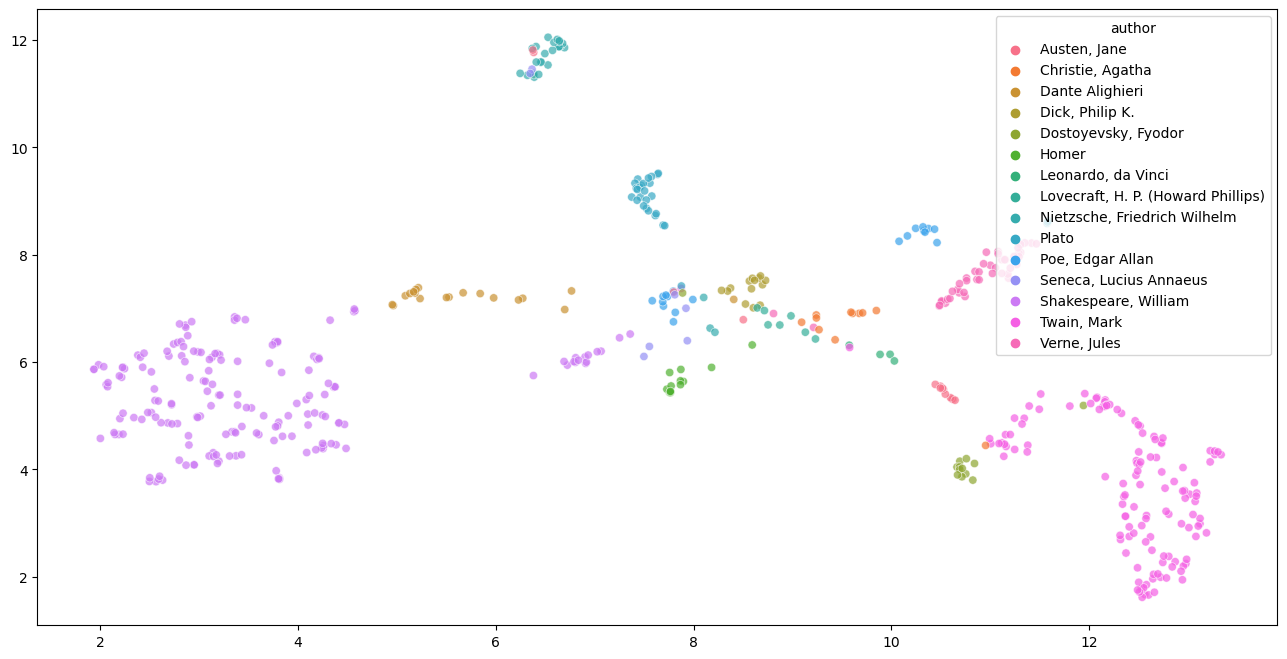

In [118]:
umap_projection = umap_mnist.transform(nn_represent_select)

plt.figure(figsize = (16,8))
sns.scatterplot(x=umap_projection[:,0], y=umap_projection[:,1], 
                hue = library_select.replace({'author': num_to_authors})['author'].astype('category'),
               alpha = 0.7);

Now to use the encoder to see how the six authors get represented in this 100-dimensional space.

In [119]:
print(library_select.shape)
print(nn_represent_select.shape)

(530, 11)
(530, 100)


In [102]:
library_select_vec = pd.DataFrame(nn_represent_select, columns=[f'dim_{x}' for x in range(100)])

In [103]:
library_select_vec = pd.concat([library_select[['title', 'author']].replace({'author': num_to_authors}),
                                 library_select_vec.set_index(library_select.index)], axis=1)

Calculating cosine similarity

In order to plot it, I'll condense the authors.

In [104]:
library_select_grouped = library_select_vec.drop(columns=['title']).groupby('author').mean()

In [105]:
dists = spatial.distance.pdist(library_select_grouped.values, metric = 'cosine')

example to calculate the dist between phillip k dick and lovecradt, need to get the correct index for dist.

Position in daataframe: 3 phillip k dick, 7 lovecraft

m * i + j - ((i + 2) * (i + 1)) // 2


In [128]:
15 * 3 + 7 - ((3+2) * (3+1)) // 2

42

In [129]:
dists[42]

0.22511220163343681

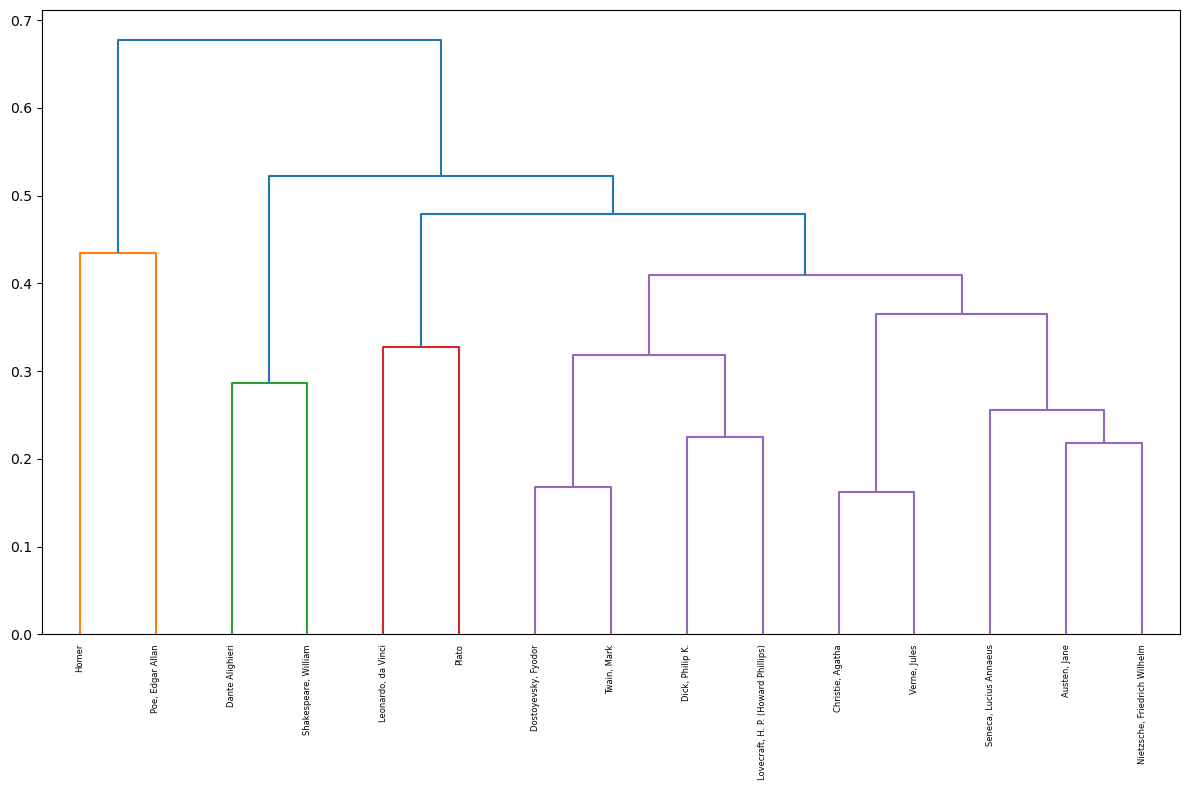

In [106]:
mergings = linkage(dists, method='complete')

plt.figure(figsize = (12,8))
dendrogram(mergings,
           labels = list(library_select_grouped.index),
           leaf_rotation = 90,
           leaf_font_size = 6);

plt.tight_layout()
#plt.savefig('images/dendogram_complete_cosine.png', transparent=False, facecolor='white', dpi = 150);

In [ ]:
# this is a bit convoluted, but .. I first concatenate all the texts in the pandas series which returns an extremely long string
# I then turn that string into a pandas series (the predict requires an iterable object)
# pipe_vect_encoder.predict(pd.Series(library_top_six.loc[library_top_six['author'] == 0]['book_content'].str.cat()))